### 一.损失函数

这一节对xgboost回归做介绍，xgboost共实现了5种类型的回归，分别是squarederror、logistic、poisson、gamma、tweedie回归，下面主要对前两种进行推导实现，剩余三种放到下一节  

#### squarederror
即损失函数为平方误差的回归模型：  

$$
L(y,\hat{y})=\frac{1}{2}(y-\hat{y})^2
$$  

所以一阶导和二阶导分别为：   

$$
\frac{\partial L(y,\hat{y})}{\partial \hat{y}}=\hat{y}-y\\
\frac{\partial^2 L(y,\hat{y})}{{\partial \hat{y}}^2}=1.0\\
$$  

#### logistic

由于是回归任务，所以y也要套上`sigmoid`函数（用$\sigma(\cdot)$表示），损失函数：   

$$
L(y,\hat{y})=(1-\sigma(y))log(1-\sigma(\hat{y}))+\sigma(y)log(\sigma(\hat{y}))
$$

一阶导和二阶导分别为：   

$$
\frac{\partial L(y,\hat{y})}{\partial \hat{y}}=\sigma(\hat{y})-\sigma(y)\\
\frac{\partial^2 L(y,\hat{y})}{{\partial \hat{y}}^2}=\sigma(\hat{y})(1-\sigma(\hat{y}))\\
$$   


### 二.代码实现
具体流程与gbdt的回归类似，只是每次要计算一阶、二阶导数信息，同时基学习器要替换为上一节的xgboost回归树

In [1]:
import os
os.chdir('../')
import matplotlib.pyplot as plt
%matplotlib inline
from ml_models.ensemble import XGBoostBaseTree
from ml_models import utils
import copy
import numpy as np

"""
xgboost回归树的实现，封装到ml_models.ensemble
"""

class XGBoostRegressor(object):
    def __init__(self, base_estimator=None, n_estimators=10, learning_rate=1.0, loss='squarederror'):
        """
        :param base_estimator: 基学习器
        :param n_estimators: 基学习器迭代数量
        :param learning_rate: 学习率，降低后续基学习器的权重，避免过拟合
        :param loss:损失函数，支持squarederror、logistic
        """
        self.base_estimator = base_estimator
        self.n_estimators = n_estimators
        self.learning_rate = learning_rate
        if self.base_estimator is None:
            # 默认使用决策树桩
            self.base_estimator = XGBoostBaseTree()
        # 同质分类器
        if type(base_estimator) != list:
            estimator = self.base_estimator
            self.base_estimator = [copy.deepcopy(estimator) for _ in range(0, self.n_estimators)]
        # 异质分类器
        else:
            self.n_estimators = len(self.base_estimator)
        self.loss = loss

    def _get_gradient_hess(self, y, y_pred):
        """
        获取一阶、二阶导数信息
        :param y:真实值
        :param y_pred:预测值
        :return:
        """
        if self.loss == 'squarederror':
            return y_pred - y, np.ones_like(y)
        elif self.loss == 'logistic':
            return utils.sigmoid(y_pred) - utils.sigmoid(y), utils.sigmoid(y_pred) * (1 - utils.sigmoid(y_pred))

    def fit(self, x, y):
        y_pred = np.zeros_like(y)
        g, h = self._get_gradient_hess(y, y_pred)
        for index in range(0, self.n_estimators):
            self.base_estimator[index].fit(x, g, h)
            y_pred += self.base_estimator[index].predict(x) * self.learning_rate
            g, h = self._get_gradient_hess(y, y_pred)

    def predict(self, x):
        rst_np = np.sum(
            [self.base_estimator[0].predict(x)] +
            [self.learning_rate * self.base_estimator[i].predict(x) for i in
             range(1, self.n_estimators - 1)] +
            [self.base_estimator[self.n_estimators - 1].predict(x)]
            , axis=0)
        return rst_np

In [2]:
#测试
data = np.linspace(1, 10, num=100)
target = np.sin(data) + np.random.random(size=100)  # 添加噪声
data = data.reshape((-1, 1))

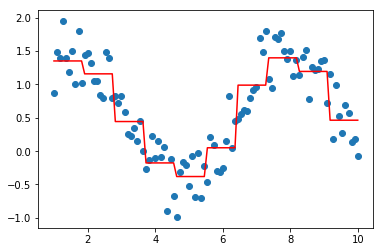

In [3]:
model = XGBoostRegressor(loss='squarederror')
model.fit(data, target)
plt.scatter(data, target)
plt.plot(data, model.predict(data), color='r')
plt.show()

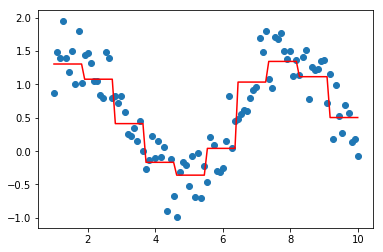

In [4]:
model = XGBoostRegressor(loss='logistic')
model.fit(data, target)
plt.scatter(data, target)
plt.plot(data, model.predict(data), color='r')
plt.show()